In [1]:
#!pip install xgboost lightgbm

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint

%matplotlib inline 

In [3]:
import warnings
warnings.simplefilter("ignore")

In [4]:
data = pd.read_csv("../artifacts/raw/train.csv")

In [5]:
data.head()

,Unnamed: 0,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,9622,INN09623,2,0,0,4,Meal Plan 1,0,Room_Type 4,238,2018,9,20,Offline,0,0,0,107.0,1,Canceled
1,30864,INN30865,2,0,2,1,Meal Plan 1,0,Room_Type 1,61,2018,9,18,Online,0,0,0,135.9,0,Canceled
2,6857,INN06858,2,0,0,3,Meal Plan 1,0,Room_Type 1,117,2018,7,7,Online,0,0,0,114.3,0,Canceled
3,9067,INN09068,2,0,2,2,Meal Plan 1,0,Room_Type 1,24,2017,12,4,Online,0,0,0,123.5,1,Not_Canceled
4,27159,INN27160,2,0,0,5,Meal Plan 1,0,Room_Type 4,162,2018,3,8,Offline,0,0,0,62.0,1,Not_Canceled


In [6]:
data.room_type_reserved.unique

<bound method Series.unique of 0        Room_Type 4
1        Room_Type 1
2        Room_Type 1
3        Room_Type 1
4        Room_Type 4
            ...     
27201    Room_Type 1
27202    Room_Type 1
27203    Room_Type 1
27204    Room_Type 1
27205    Room_Type 1
Name: room_type_reserved, Length: 27206, dtype: object>

In [7]:
data.booking_status.value_counts()

booking_status
Not_Canceled    18279
Canceled         8927
Name: count, dtype: int64

In [8]:
data.head()

,Unnamed: 0,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,9622,INN09623,2,0,0,4,Meal Plan 1,0,Room_Type 4,238,2018,9,20,Offline,0,0,0,107.0,1,Canceled
1,30864,INN30865,2,0,2,1,Meal Plan 1,0,Room_Type 1,61,2018,9,18,Online,0,0,0,135.9,0,Canceled
2,6857,INN06858,2,0,0,3,Meal Plan 1,0,Room_Type 1,117,2018,7,7,Online,0,0,0,114.3,0,Canceled
3,9067,INN09068,2,0,2,2,Meal Plan 1,0,Room_Type 1,24,2017,12,4,Online,0,0,0,123.5,1,Not_Canceled
4,27159,INN27160,2,0,0,5,Meal Plan 1,0,Room_Type 4,162,2018,3,8,Offline,0,0,0,62.0,1,Not_Canceled


In [9]:
data.duplicated().sum()

np.int64(0)

In [10]:
data.drop_duplicates(inplace=True)

In [11]:
data.drop(labels=["Unnamed: 0", "Booking_ID"], axis = 1, inplace=True)

In [12]:
data["no_of_weekend_nights"].value_counts()

no_of_weekend_nights
0    12610
1     7541
2     6798
3      113
4      101
5       28
6       15
Name: count, dtype: int64

In [13]:
data.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,27206.000000,27206.000000,27206.000000,27206.000000,27206.000000,27206.000000,27206.000000,27206.000000,27206.000000,27206.000000,27206.000000,27206.000000,27206.000000,27206.000000
mean,1.840844,0.105712,0.812688,2.205984,0.031170,85.125708,2017.819562,7.429280,15.594317,0.024958,0.022863,0.148901,103.581534,0.622988
std,0.519385,0.402801,0.870971,1.414391,0.173779,85.795619,0.384559,3.062466,8.720946,0.155999,0.358876,1.732972,35.046820,0.786768
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.750000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.900000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.685000,1.000000
max,4.000000,9.000000,6.000000,16.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [14]:
data.required_car_parking_space.value_counts()

required_car_parking_space
0    26358
1      848
Name: count, dtype: int64

In [15]:
cat_col = ['type_of_meal_plan','room_type_reserved',"required_car_parking_space","market_segment_type", "booking_status","repeated_guest"]

num_col = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights','no_of_week_nights','lead_time', 'arrival_year', 'arrival_month','arrival_date','no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled','avg_price_per_room', 'no_of_special_requests']

In [16]:
df = data.copy()

In [17]:
df.shape

(27206, 18)

In [18]:
def num_plot_distribution(df, no_of_features):
    fig, axes = plt.subplots(len(no_of_features), 2,figsize = (15, len(no_of_features)*5))
    
    if no_of_features == 1:
        axes = [axes]
        
    for i,column in enumerate(no_of_features):
        sns.histplot(data = df, x = column, ax= axes[i][0], kde = True, palette="Blues")
        axes[i][0].set_title(f"Histogram for {column}")
        
        sns.boxplot(data = df, x = column, ax= axes[i][1], palette="Blues")
        axes[i][1].set_title(f"Boxplot for {column}")
    
    plt.tight_layout()
    plt.show()
    
    

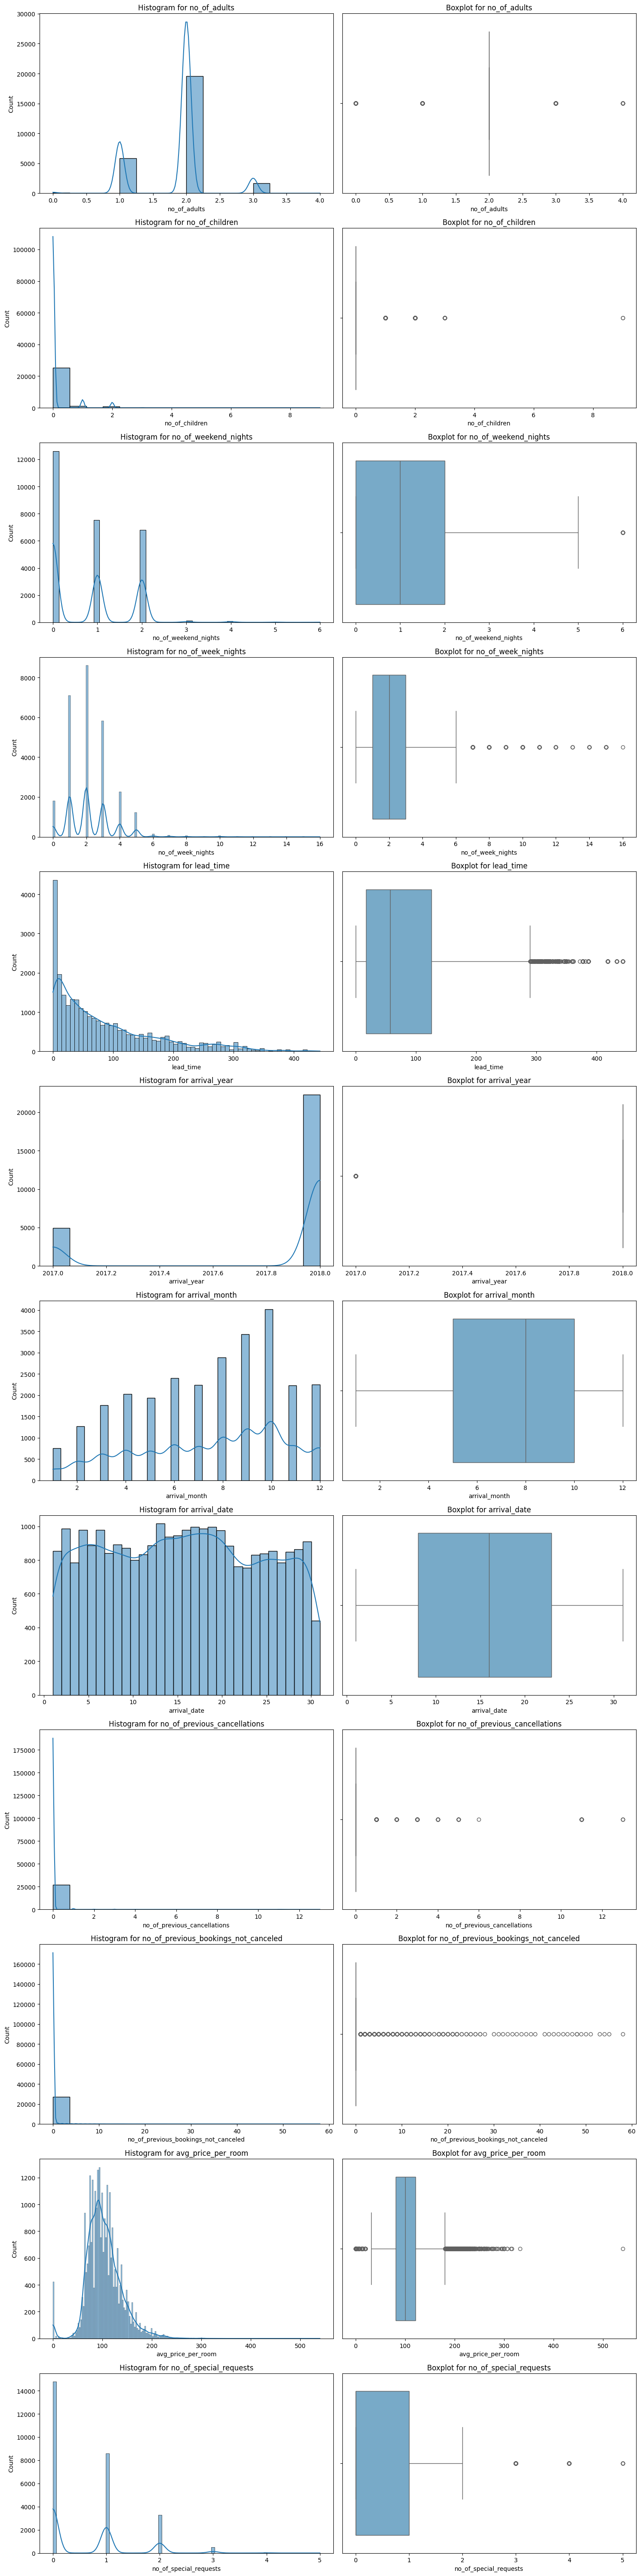

In [19]:
num_plot_distribution(df, num_col)

In [20]:
def cat_col_distribution(data, no_of_feature):
    for column in no_of_feature:
        plt.figure(figsize=(15, 5))
        data[column].value_counts().plot(kind="bar",color="blue")
        plt.title(f"Bar chart for {column}")
        plt.xlabel(column)
        plt.ylabel("count")
        plt.show()

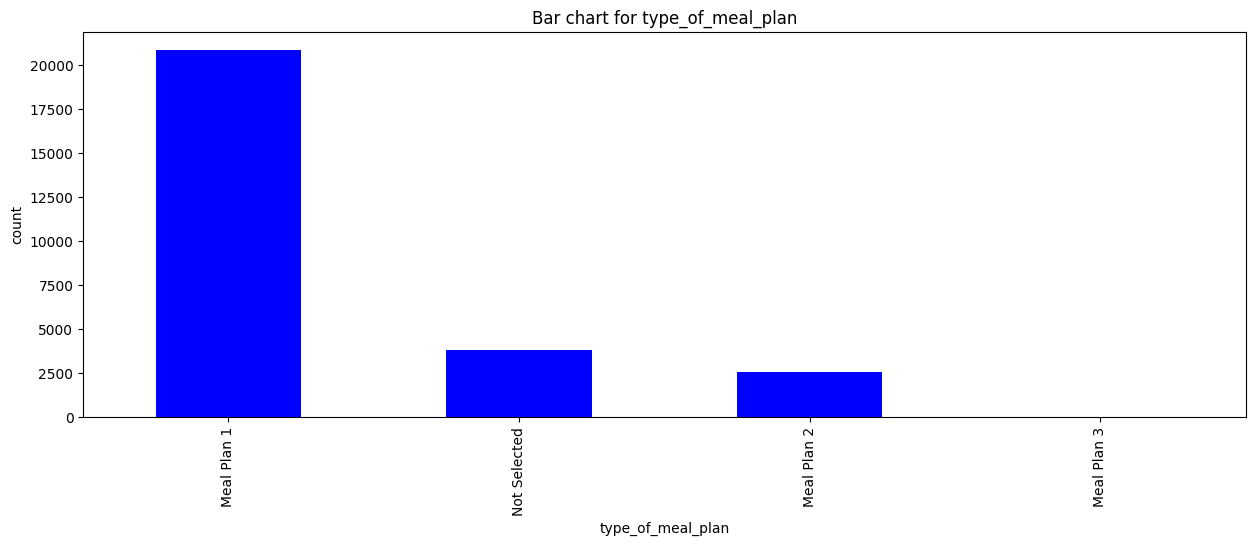

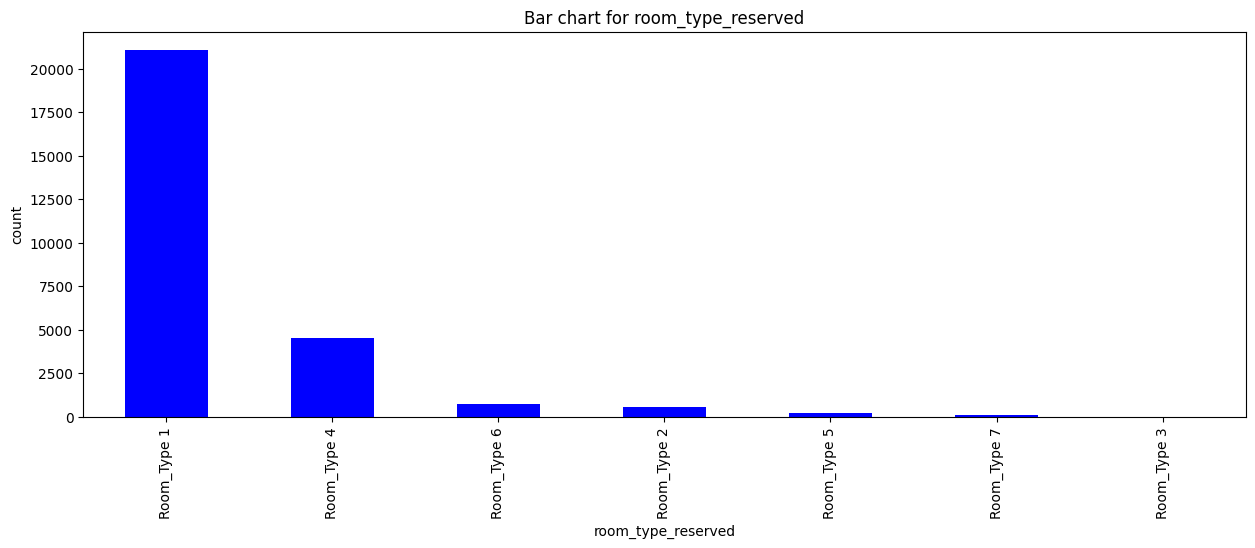

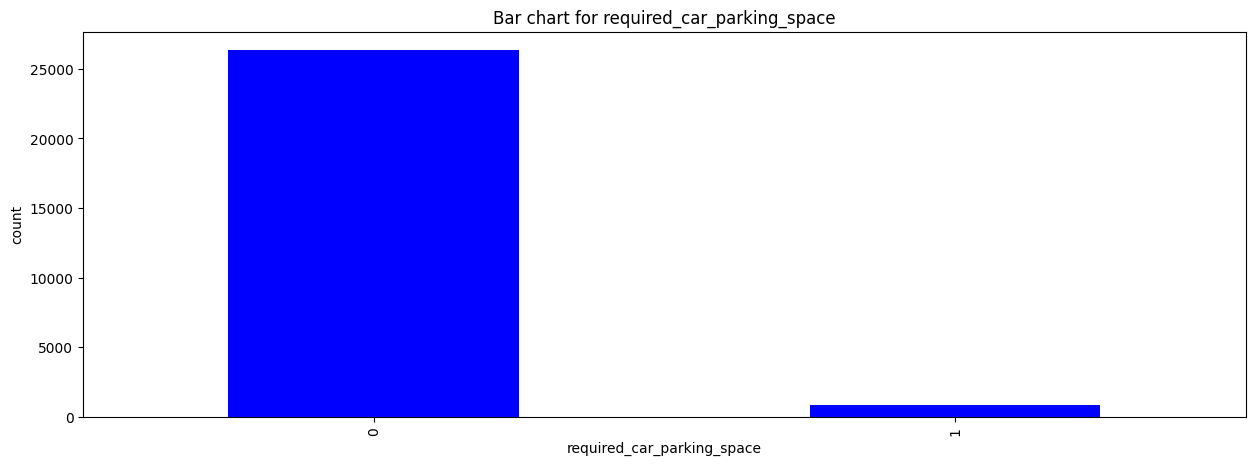

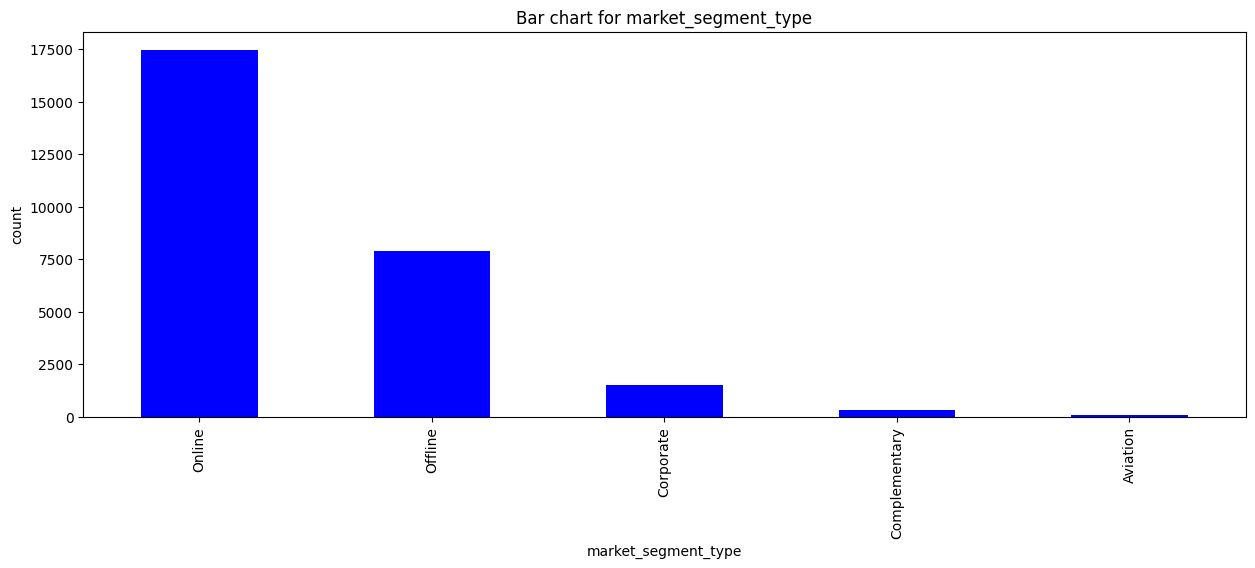

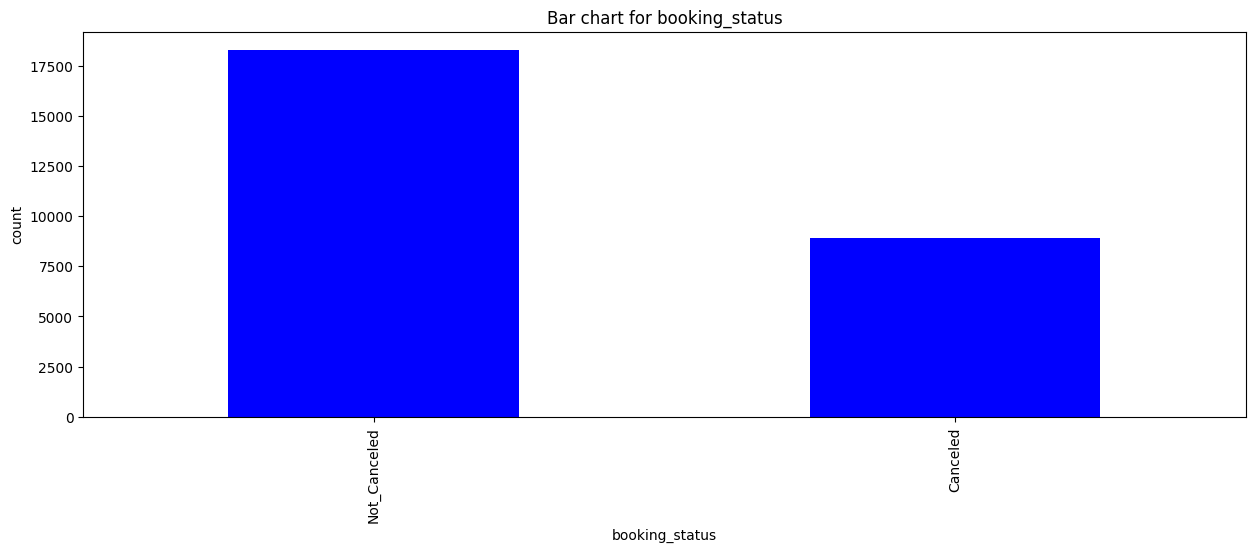

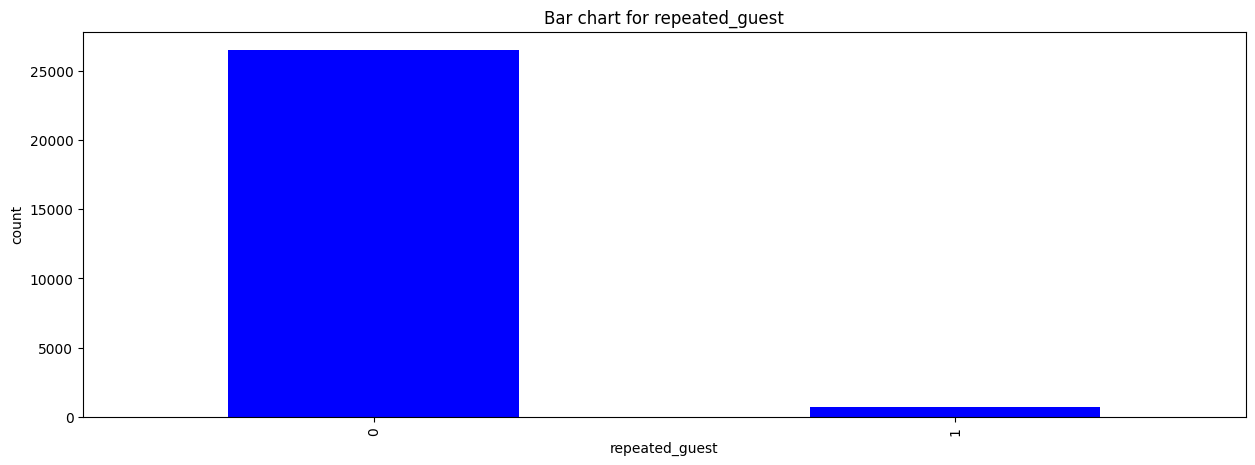

In [21]:
cat_col_distribution(df, cat_col)

In [22]:
def plot_bivariate_num(data, target, no_of_features):
    fig, axes = plt.subplots((len(no_of_features)+1)//2, 2 , figsize = (15, len(no_of_features)*3))
    axes = axes.flatten()
    for i,column in enumerate(no_of_features):
        sns.boxplot(data = data, y = column, x= target, palette="Blues", ax=axes[i])
        axes[i].set_title(f"{column} vs {target}")
    
    plt.tight_layout()
    plt.show()

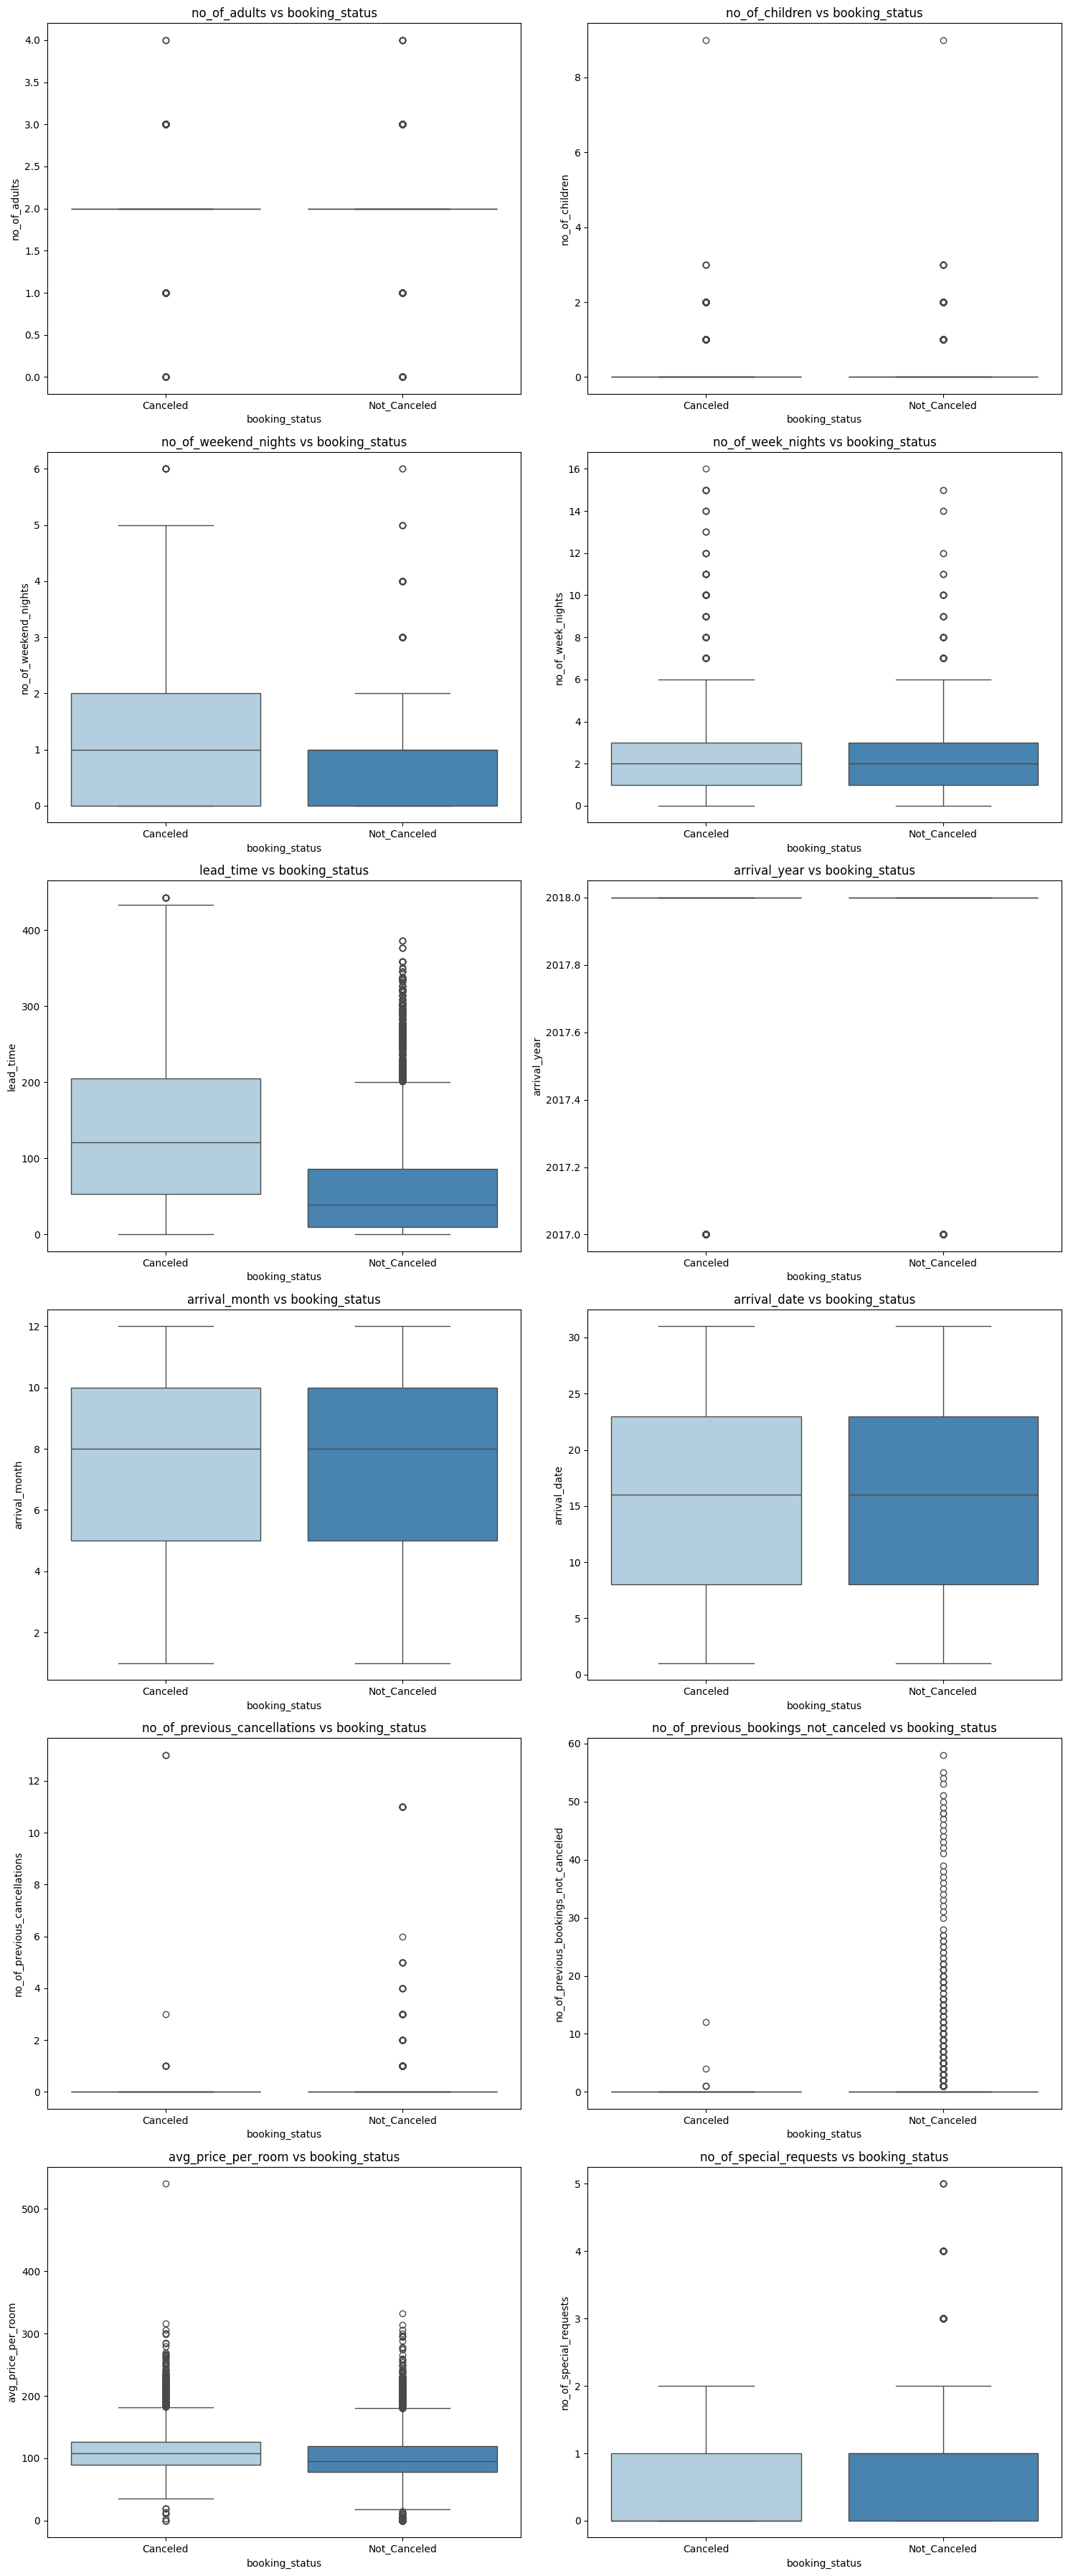

In [23]:
plot_bivariate_num(df, "booking_status", num_col)

In [24]:
def plot_bivariate_cat(data, target, cat_features):
    num_rows = (len(cat_features)+1)//2
    
    fig ,axes = plt.subplots(num_rows , 2, figsize=(15, len(cat_features)*3))
    
    axes = axes.flatten()
    
    for i,column in enumerate(cat_features):
        sns.countplot(data = data, x = column, hue = target, palette="Blues", ax=axes[i] )
        axes[i].set_title(f"{column} vs {target}")
        axes[i].tick_params(axis ="x",rotation=45)
        
    plt.tight_layout()
    plt.show()

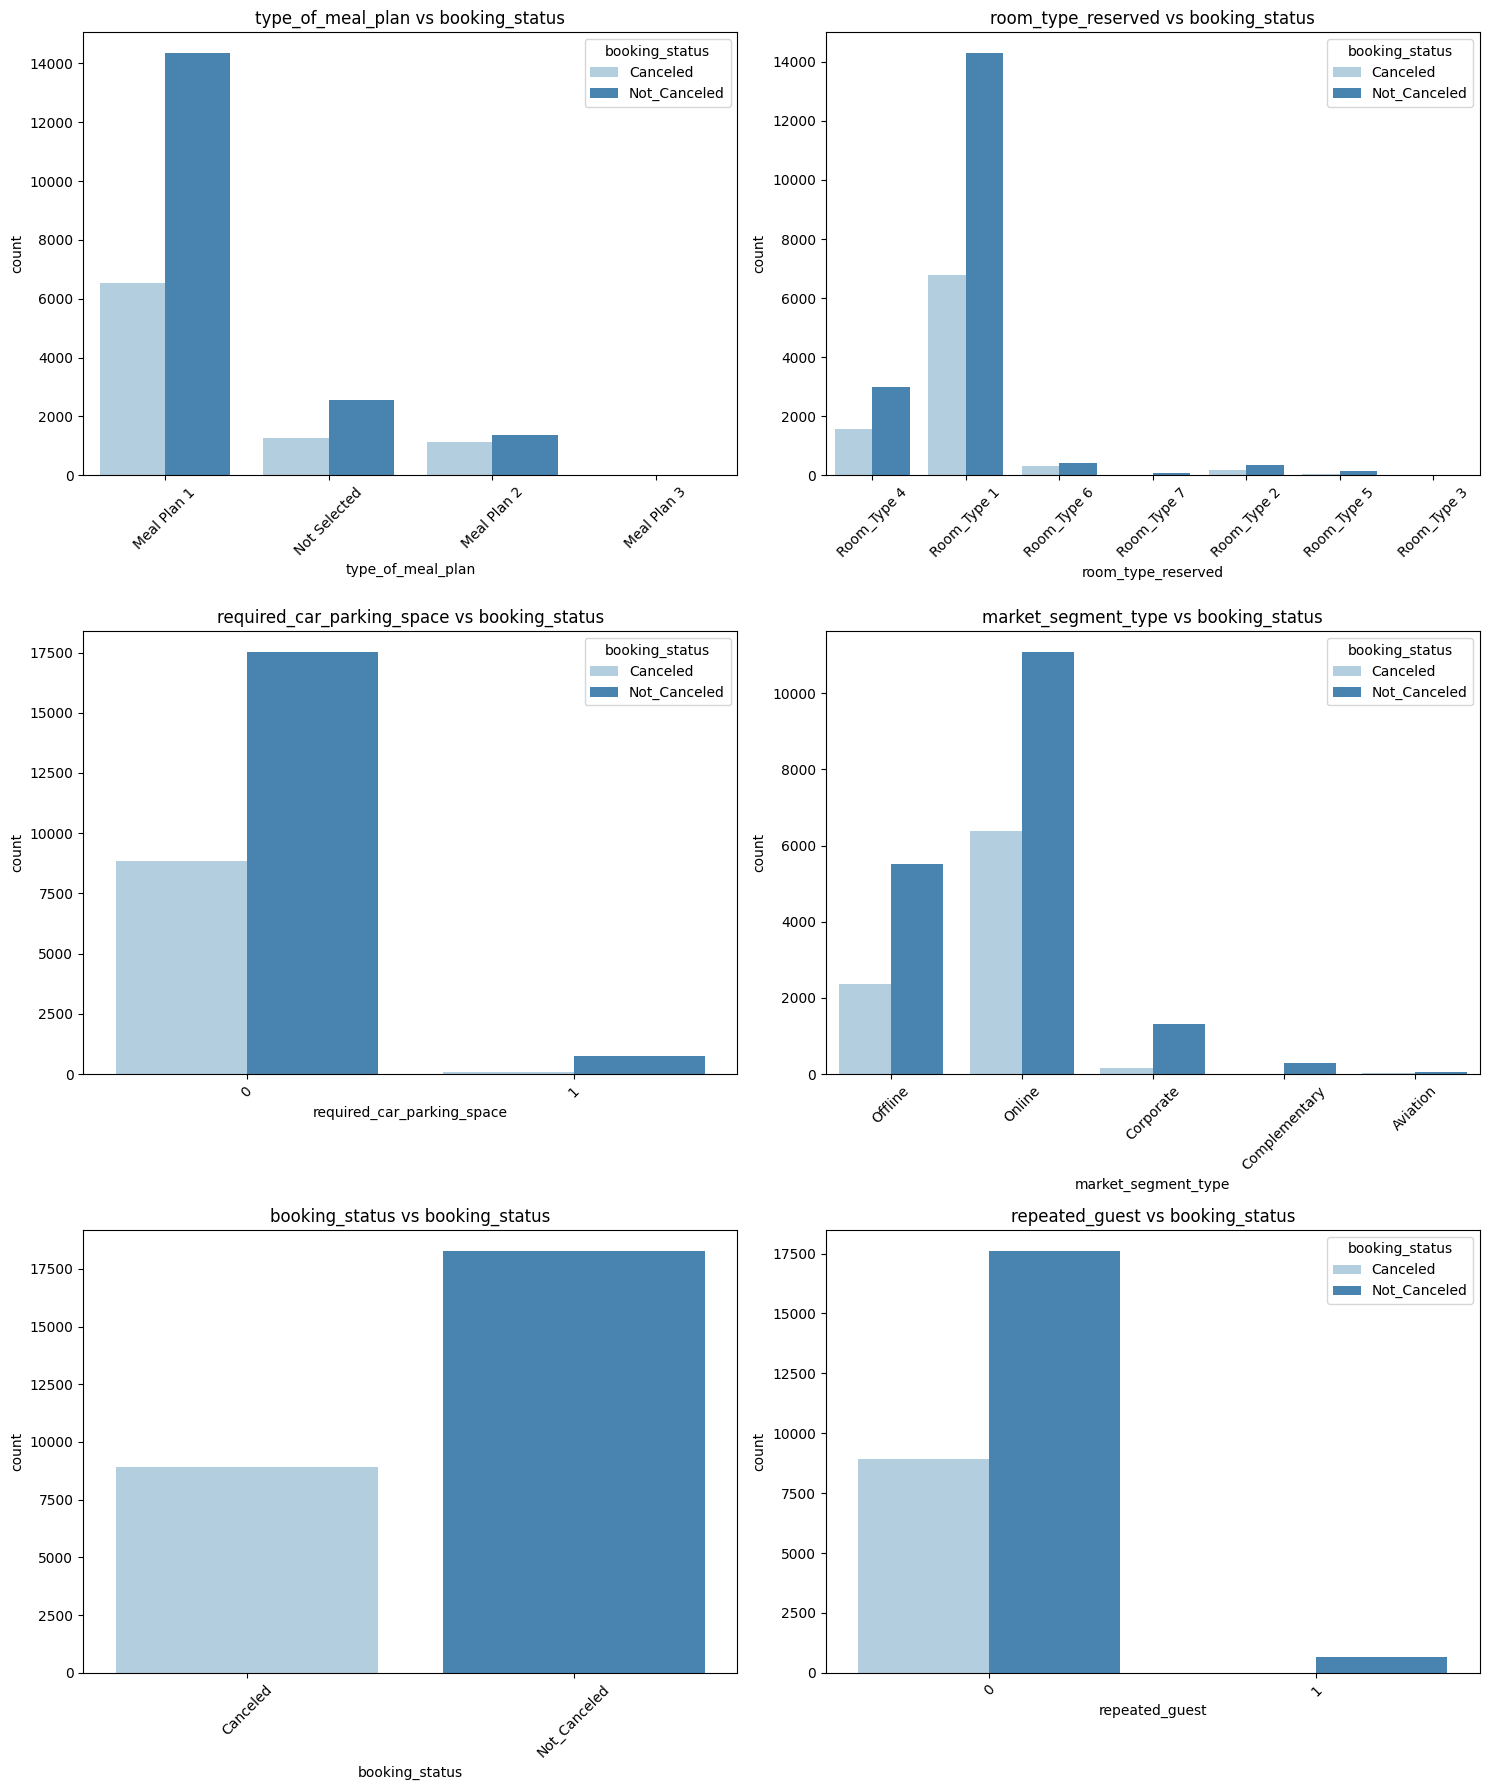

In [25]:
plot_bivariate_cat(df, "booking_status", cat_col)

In [26]:
le = LabelEncoder()

In [27]:
mapping = {}

for column in cat_col:
    df[column] = le.fit_transform(df[column])    
    mapping[column] = {label:code for label, code in zip(le.classes_, le.transform(le.classes_) ) }

In [28]:
mapping

{'type_of_meal_plan': {'Meal Plan 1': np.int64(0),
  'Meal Plan 2': np.int64(1),
  'Meal Plan 3': np.int64(2),
  'Not Selected': np.int64(3)},
 'room_type_reserved': {'Room_Type 1': np.int64(0),
  'Room_Type 2': np.int64(1),
  'Room_Type 3': np.int64(2),
  'Room_Type 4': np.int64(3),
  'Room_Type 5': np.int64(4),
  'Room_Type 6': np.int64(5),
  'Room_Type 7': np.int64(6)},
 'required_car_parking_space': {np.int64(0): np.int64(0),
  np.int64(1): np.int64(1)},
 'market_segment_type': {'Aviation': np.int64(0),
  'Complementary': np.int64(1),
  'Corporate': np.int64(2),
  'Offline': np.int64(3),
  'Online': np.int64(4)},
 'booking_status': {'Canceled': np.int64(0), 'Not_Canceled': np.int64(1)},
 'repeated_guest': {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}}

In [29]:
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,0,4,0,0,3,238,2018,9,20,3,0,0,0,107.0,1,0
1,2,0,2,1,0,0,0,61,2018,9,18,4,0,0,0,135.9,0,0
2,2,0,0,3,0,0,0,117,2018,7,7,4,0,0,0,114.3,0,0
3,2,0,2,2,0,0,0,24,2017,12,4,4,0,0,0,123.5,1,1
4,2,0,0,5,0,0,3,162,2018,3,8,3,0,0,0,62.0,1,1


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27206 entries, 0 to 27205
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          27206 non-null  int64  
 1   no_of_children                        27206 non-null  int64  
 2   no_of_weekend_nights                  27206 non-null  int64  
 3   no_of_week_nights                     27206 non-null  int64  
 4   type_of_meal_plan                     27206 non-null  int64  
 5   required_car_parking_space            27206 non-null  int64  
 6   room_type_reserved                    27206 non-null  int64  
 7   lead_time                             27206 non-null  int64  
 8   arrival_year                          27206 non-null  int64  
 9   arrival_month                         27206 non-null  int64  
 10  arrival_date                          27206 non-null  int64  
 11  market_segment_

In [31]:
x = add_constant(df)

vif_df = pd.DataFrame()

vif_df["features"] = x.columns

vif_df["VIF"] = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]

In [32]:
vif_df

,features,VIF
0,const,3.572126e+07
1,no_of_adults,1.283430e+00
2,no_of_children,1.259433e+00
3,no_of_weekend_nights,1.067677e+00
4,no_of_week_nights,1.091028e+00
5,type_of_meal_plan,1.151944e+00
6,required_car_parking_space,1.033803e+00
7,room_type_reserved,1.522279e+00
8,lead_time,1.435019e+00
9,arrival_year,1.297410e+00


In [33]:
corr = df.corr()

In [34]:
corr

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
no_of_adults,1.000000,-0.021834,0.105547,0.101070,0.026864,0.014647,0.264368,0.095742,0.077240,0.023382,0.029973,0.310446,-0.187335,-0.047725,-0.118116,0.290306,0.190568,-0.086334
no_of_children,-0.021834,1.000000,0.022601,0.017975,-0.087521,0.038521,0.365115,-0.043902,0.049819,-0.003296,0.026534,0.132536,-0.035554,-0.016466,-0.021023,0.339873,0.124837,-0.034266
no_of_weekend_nights,0.105547,0.022601,1.000000,0.182424,-0.023794,-0.032339,0.054349,0.046119,0.056682,-0.009225,0.026721,0.132345,-0.066231,-0.020167,-0.025941,-0.007894,0.062961,-0.065536
no_of_week_nights,0.101070,0.017975,0.182424,1.000000,-0.084597,-0.051845,0.090216,0.152321,0.026301,0.043613,-0.006120,0.107427,-0.099767,-0.030279,-0.046496,0.015321,0.044817,-0.093827
type_of_meal_plan,0.026864,-0.087521,-0.023794,-0.084597,1.000000,-0.010136,-0.208252,-0.059880,0.072353,0.004742,0.007295,0.199936,-0.064615,-0.017764,-0.038926,-0.066582,0.020760,-0.024917
required_car_parking_space,0.014647,0.038521,-0.032339,-0.051845,-0.010136,1.000000,0.043012,-0.067497,0.017607,-0.012434,-0.003710,-0.003921,0.108250,0.022169,0.052086,0.065968,0.087835,0.086606
room_type_reserved,0.264368,0.365115,0.054349,0.090216,-0.208252,0.043012,1.000000,-0.103484,0.102334,-0.001660,0.033251,0.159371,-0.025405,-0.004272,-0.011502,0.466901,0.143625,-0.025428
lead_time,0.095742,-0.043902,0.046119,0.152321,-0.059880,-0.067497,-0.103484,1.000000,0.146013,0.134972,0.005888,-0.010032,-0.133929,-0.045375,-0.077347,-0.064067,-0.103122,-0.433634
arrival_year,0.077240,0.049819,0.056682,0.026301,0.072353,0.017607,0.102334,0.146013,1.000000,-0.337887,0.022003,0.148429,-0.018677,0.003524,0.027190,0.176264,0.053607,-0.178078
arrival_month,0.023382,-0.003296,-0.009225,0.043613,0.004742,-0.012434,-0.001660,0.134972,-0.337887,1.000000,-0.037999,-0.004244,0.002733,-0.033947,-0.008395,0.055844,0.107601,0.012607


<Axes: >

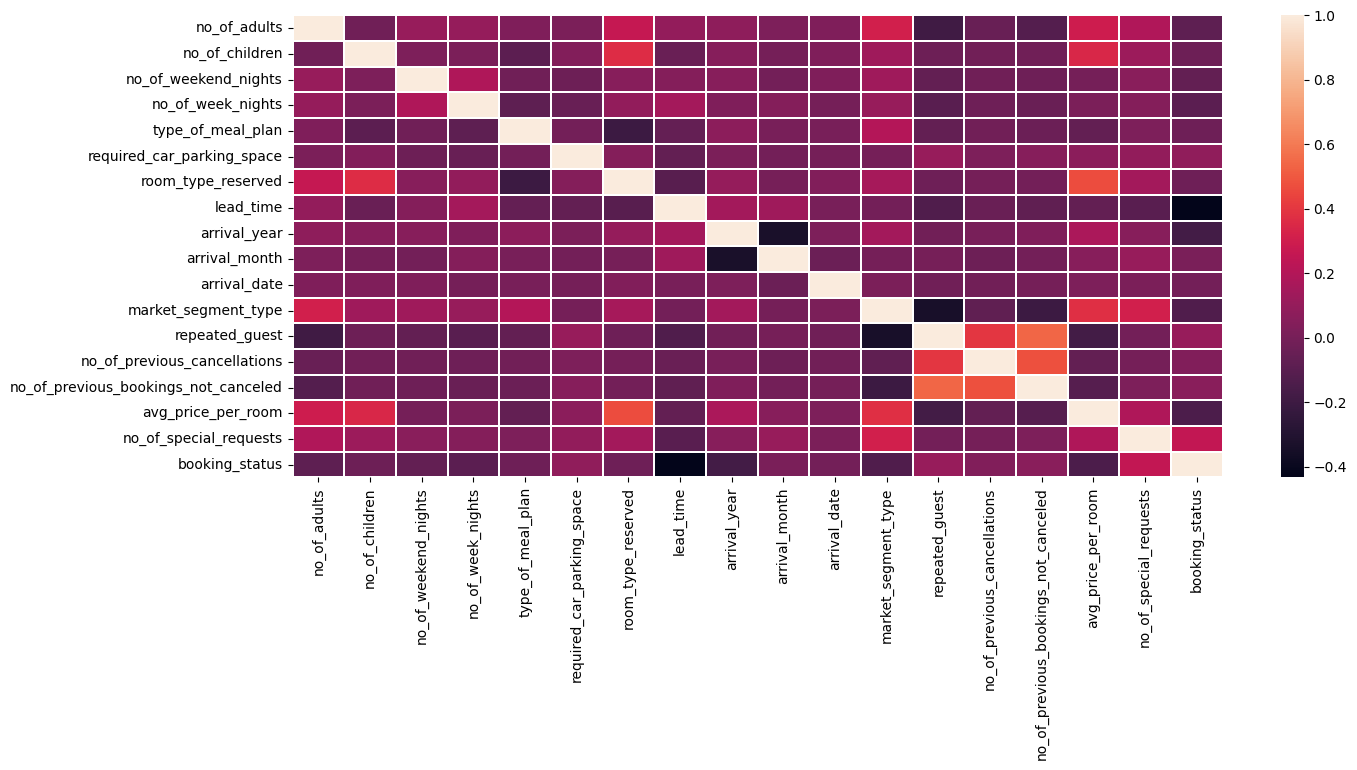

In [35]:
plt.figure(figsize=(15,6))

sns.heatmap(corr, linewidths=0.2)

In [36]:
skewness = df.skew()

In [37]:
skewness

no_of_adults                            -0.342196
no_of_children                           4.534781
no_of_weekend_nights                     0.737855
no_of_week_nights                        1.568402
type_of_meal_plan                        1.810893
required_car_parking_space               5.396103
room_type_reserved                       1.724023
lead_time                                1.283789
arrival_year                            -1.662087
arrival_month                           -0.352503
arrival_date                             0.029587
market_segment_type                     -1.688648
repeated_guest                           6.090766
no_of_previous_cancellations            25.485266
no_of_previous_bookings_not_canceled    19.609927
avg_price_per_room                       0.651482
no_of_special_requests                   1.134010
booking_status                          -0.732149
dtype: float64

In [38]:
for col in df.columns:
    if skewness[col] > 5:
        df[col] = np.log1p(df[col])

In [39]:
df.skew()

no_of_adults                            -0.342196
no_of_children                           4.534781
no_of_weekend_nights                     0.737855
no_of_week_nights                        1.568402
type_of_meal_plan                        1.810893
required_car_parking_space               5.396103
room_type_reserved                       1.724023
lead_time                                1.283789
arrival_year                            -1.662087
arrival_month                           -0.352503
arrival_date                             0.029587
market_segment_type                     -1.688648
repeated_guest                           6.090766
no_of_previous_cancellations            14.486077
no_of_previous_bookings_not_canceled     9.043640
avg_price_per_room                       0.651482
no_of_special_requests                   1.134010
booking_status                          -0.732149
dtype: float64

In [40]:
df.booking_status.value_counts(normalize=True)

booking_status
1    0.671874
0    0.328126
Name: proportion, dtype: float64

In [41]:
X = df.drop(columns="booking_status")
Y = df["booking_status"]

In [42]:
smote = SMOTE(sampling_strategy="minority", random_state=7)

In [43]:
x_res, y_res = smote.fit_resample(X,Y)

In [44]:
y_res.value_counts()

booking_status
0    18279
1    18279
Name: count, dtype: int64

In [45]:
balanced_df = pd.DataFrame(x_res, columns=X.columns)
balanced_df["booking_status"] = y_res

In [46]:
balanced_df.shape

(36558, 18)

In [47]:
df = balanced_df.copy()

In [48]:
X = df.drop(columns="booking_status")
Y = df["booking_status"]

In [49]:
model = RandomForestClassifier()

In [50]:
model.fit(X,Y)

RandomForestClassifier()

In [51]:
feature_importance = model.feature_importances_

In [52]:
feature_importance_df = pd.DataFrame({
    "feature" : X.columns,
    "importance": feature_importance
})

In [53]:
top_features_df = feature_importance_df.sort_values(by="importance", ascending=False)

In [54]:
top_10_features = top_features_df["feature"].head(10).values

In [55]:
top_10_df = df[top_10_features.tolist() + ["booking_status"]]

In [56]:
top_10_df

,lead_time,avg_price_per_room,no_of_special_requests,arrival_month,arrival_date,market_segment_type,no_of_week_nights,no_of_weekend_nights,arrival_year,no_of_adults,booking_status
0,238,107.000000,1,9,20,3,4,0,2018,2,0
1,61,135.900000,0,9,18,4,1,2,2018,2,0
2,117,114.300000,0,7,7,4,3,0,2018,2,0
3,24,123.500000,1,12,4,4,2,2,2017,2,1
4,162,62.000000,1,3,8,3,5,0,2018,2,1
...,...,...,...,...,...,...,...,...,...,...,...
36553,171,168.071523,2,7,7,4,1,0,2018,2,0
36554,106,117.568329,1,10,20,4,3,1,2018,2,0
36555,121,90.000000,0,6,24,3,2,1,2018,2,0
36556,86,121.509922,0,11,8,4,2,0,2018,2,0


In [57]:
df = top_10_df.copy()

In [58]:
X = df.drop(columns="booking_status")
Y = df["booking_status"]

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25,stratify=Y )

In [60]:
X_test.shape

(9140, 10)

In [61]:
model_classifiers  = {
    "LogisticRegression" : LogisticRegression(random_state=36),
    "SVC" : SVC(random_state=36),
    "DecisionTree": DecisionTreeClassifier(random_state=36),
    "KNN" : KNeighborsClassifier(),
    "NaiveByes": GaussianNB(),
    "XGBoost": XGBClassifier(random_state=36),
    "LightGBM" : LGBMClassifier(random_state=36),
    "RandomForest": RandomForestClassifier(random_state=36),
    "GradientBoosting" : GradientBoostingClassifier(random_state=36),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=36)
}

In [62]:
metrics = {
    "Model" : [],
    "Accuracy" : [],
    "Precision" : [],
    "Recall": [],
    "F1 Score" : []
}

In [63]:
for model_name, classifier in model_classifiers.items():
    classifier.fit(X_train, Y_train)
    Y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)    
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    
    metrics["Model"].append(model_name)
    metrics["Accuracy"].append(accuracy)
    metrics["Recall"].append(recall)
    metrics["Precision"].append(precision)
    metrics["F1 Score"].append(f1)
    

[LightGBM] [Info] Number of positive: 13709, number of negative: 13709
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 582
[LightGBM] [Info] Number of data points in the train set: 27418, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [64]:
metrics

{'Model': ['LogisticRegression',
  'SVC',
  'DecisionTree',
  'KNN',
  'NaiveByes',
  'XGBoost',
  'LightGBM',
  'RandomForest',
  'GradientBoosting',
  'AdaBoostClassifier'],
 'Accuracy': [0.7773522975929978,
  0.6896061269146608,
  0.874070021881838,
  0.8227571115973742,
  0.7447483588621444,
  0.887527352297593,
  0.8774617067833698,
  0.911487964989059,
  0.8347921225382933,
  0.7925601750547046],
 'Precision': [0.7804824076123036,
  0.6569462053975729,
  0.8823529411764706,
  0.8520286396181385,
  0.7624970664163342,
  0.8870192307692307,
  0.8687473279179136,
  0.9101417666303162,
  0.8294573643410853,
  0.8028998640688718],
 'Recall': [0.7717724288840263,
  0.7936542669584246,
  0.8632385120350109,
  0.7811816192560175,
  0.7109409190371991,
  0.888183807439825,
  0.8892778993435448,
  0.913129102844639,
  0.8428884026258205,
  0.775492341356674],
 'F1 Score': [0.7761029816261414,
  0.7188583886631652,
  0.8726910739962394,
  0.815068493150685,
  0.7358170082663344,
  0.8876011

In [65]:
metrics_df = pd.DataFrame(data = metrics)

In [66]:
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score
0,LogisticRegression,0.777352,0.780482,0.771772,0.776103
1,SVC,0.689606,0.656946,0.793654,0.718858
2,DecisionTree,0.874070,0.882353,0.863239,0.872691
3,KNN,0.822757,0.852029,0.781182,0.815068
4,NaiveByes,0.744748,0.762497,0.710941,0.735817
5,XGBoost,0.887527,0.887019,0.888184,0.887601
6,LightGBM,0.877462,0.868747,0.889278,0.878893
7,RandomForest,0.911488,0.910142,0.913129,0.911633
8,GradientBoosting,0.834792,0.829457,0.842888,0.836119
9,AdaBoostClassifier,0.792560,0.802900,0.775492,0.788958


In [68]:
X = df.drop(columns="booking_status")
Y = df["booking_status"]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25,stratify=Y, random_state= 36)


In [ ]:
rf = RandomForestClassifier(random_state=36)

In [70]:
param_dists = {
    "n_estimators": randint(100,500),
    "max_depth": randint(10,50),
    "criterion": ['gini', 'entropy', 'log_loss'],
    "min_samples_split": randint(2,10),
    "min_samples_leaf": randint(2,5), 
    "bootstrap":  [True, False]
        
}

In [ ]:
random_search = RandomizedSearchCV(
    estimator = rf,
    param_distributions=param_dists,
    verbose=2,
    n_iter = 5,
    cv = 2,
    random_state=36,
    scoring="accuracy"
)

In [72]:
random_search.fit(X_train, Y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END bootstrap=False, criterion=log_loss, max_depth=40, min_samples_leaf=2, min_samples_split=3, n_estimators=350; total time=  17.3s
[CV] END bootstrap=False, criterion=log_loss, max_depth=40, min_samples_leaf=2, min_samples_split=3, n_estimators=350; total time=  17.0s
[CV] END bootstrap=True, criterion=gini, max_depth=19, min_samples_leaf=3, min_samples_split=9, n_estimators=490; total time=  14.1s
[CV] END bootstrap=True, criterion=gini, max_depth=19, min_samples_leaf=3, min_samples_split=9, n_estimators=490; total time=  13.3s
[CV] END bootstrap=True, criterion=gini, max_depth=37, min_samples_leaf=4, min_samples_split=8, n_estimators=387; total time=  10.5s
[CV] END bootstrap=True, criterion=gini, max_depth=37, min_samples_leaf=4, min_samples_split=8, n_estimators=387; total time=  10.6s
[CV] END bootstrap=False, criterion=entropy, max_depth=32, min_samples_leaf=2, min_samples_split=6, n_estimators=264; total time=  1

RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(random_state=36),
                   n_iter=5,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000221E2628830>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000221E2CEFDA0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000221E2CBD9A0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000221E20EAE40>},
                   random_state=36, scoring='accuracy', verbose=2)

In [77]:
best_rf_model = random_search.best_estimator_

In [79]:
Y_pred = best_rf_model.predict(X_test)

In [81]:
accuracy = accuracy_score(Y_test, Y_pred)    
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

In [82]:
accuracy

0.9130196936542669

In [83]:
precision

0.9035706649561684

In [84]:
recall

0.9247264770240701

In [85]:
f1

0.9140261706499405

In [86]:
import joblib

joblib.dump(best_rf_model, "random_forest.pkl")

['random_forest.pkl']